In [1]:
from google.colab import files
uploaded = files.upload()


Saving archive.zip to archive.zip


In [2]:
!ls


archive.zip  sample_data


In [3]:
!unzip archive.zip


Streaming output truncated to the last 5000 lines.
  inflating: input/Non Demented/OAS1_0006_MR1_mpr-1_124.jpg  
  inflating: input/Non Demented/OAS1_0006_MR1_mpr-1_125.jpg  
  inflating: input/Non Demented/OAS1_0006_MR1_mpr-1_126.jpg  
  inflating: input/Non Demented/OAS1_0006_MR1_mpr-1_127.jpg  
  inflating: input/Non Demented/OAS1_0006_MR1_mpr-1_128.jpg  
  inflating: input/Non Demented/OAS1_0006_MR1_mpr-1_129.jpg  
  inflating: input/Non Demented/OAS1_0006_MR1_mpr-1_130.jpg  
  inflating: input/Non Demented/OAS1_0006_MR1_mpr-1_131.jpg  
  inflating: input/Non Demented/OAS1_0006_MR1_mpr-1_132.jpg  
  inflating: input/Non Demented/OAS1_0006_MR1_mpr-1_133.jpg  
  inflating: input/Non Demented/OAS1_0006_MR1_mpr-1_134.jpg  
  inflating: input/Non Demented/OAS1_0006_MR1_mpr-1_135.jpg  
  inflating: input/Non Demented/OAS1_0006_MR1_mpr-1_136.jpg  
  inflating: input/Non Demented/OAS1_0006_MR1_mpr-1_137.jpg  
  inflating: input/Non Demented/OAS1_0006_MR1_mpr-1_138.jpg  
  inflating: input/

In [4]:
!ls


archive.zip  input  sample_data


In [5]:
!ls input


'Mild Dementia'  'Moderate Dementia'  'Non Demented'  'Very mild Dementia'


In [6]:
!pip install numpy opencv-python scikit-image scikit-learn matplotlib minisom


  Preparing metadata (setup.py) ... done
  Created wheel for minisom: filename=MiniSom-2.3.5-py3-none-any.whl size=12031 sha256=932dbd8b087147faeb296ef7262a35fe47bbd87c793926063969a9e36c2f1051
  Stored in directory: /root/.cache/pip/wheels/0f/8c/a4/5b7aa56fa6ef11d536d45da775bcc5a2a1c163ff0f8f11990b
Successfully built minisom


In [41]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

from skimage.feature import hog
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier


In [42]:
DATASET_PATH = "/content/input"
IMG_SIZE = 128

X = []
y = []
class_names = os.listdir(DATASET_PATH)

for label, class_name in enumerate(class_names):
    class_path = os.path.join(DATASET_PATH, class_name)

    for img_name in os.listdir(class_path):
        img_path = os.path.join(class_path, img_name)

        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))

        X.append(img)
        y.append(label)

X = np.array(X)
y = np.array(y)

print("Total images:", X.shape[0])
print("Image shape:", X.shape[1:])
print("Class distribution:", np.bincount(y))


Total images: 9488
Image shape: (128, 128)
Class distribution: [3000  488 3000 3000]


In [43]:
def extract_hog_features(images):
    features = []
    for img in images:
        hog_feat = hog(
            img,
            orientations=9,
            pixels_per_cell=(16, 16),
            cells_per_block=(2, 2),
            block_norm='L2-Hys'
        )
        features.append(hog_feat)
    return np.array(features)

X_features = extract_hog_features(X)

print("Feature vector shape:", X_features.shape)


Feature vector shape: (9488, 1764)


In [64]:
X_train, X_test, y_train, y_test = train_test_split(
    X_features, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


In [65]:
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

print("After SMOTE:", np.bincount(y_train_sm))


After SMOTE: [2400 2400 2400 2400]


In [66]:
scaler = StandardScaler()
X_train_sm = scaler.fit_transform(X_train_sm)
X_test_scaled = scaler.transform(X_test)


In [67]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

classes = np.unique(y_train_sm)
weights = compute_class_weight(
    class_weight="balanced",
    classes=classes,
    y=y_train_sm
)

class_weight_dict = dict(zip(classes, weights))
sample_weights = np.array([class_weight_dict[y] for y in y_train_sm])
print(class_weight_dict)


{np.int64(0): np.float64(1.0), np.int64(1): np.float64(1.0), np.int64(2): np.float64(1.0), np.int64(3): np.float64(1.0)}


In [68]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier(
    objective="multi:softprob",
    num_class=len(class_names),
    n_estimators=150,
    learning_rate=0.01,
    max_depth=3,
    min_child_weight=5,
    subsample=0.7,
    colsample_bytree=0.7,
    gamma=0.3,
    eval_metric="mlogloss",
    random_state=42,
    n_jobs=2,
    verbosity=1
)

xgb_model.fit(
    X_train_sm,
    y_train_sm,
    sample_weight=sample_weights
)



XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=0.3,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=5, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=150, n_jobs=2, num_class=4, ...)

In [69]:
y_pred = xgb_model.predict(X_test_scaled)

acc = accuracy_score(y_test, y_pred)
print("Accuracy:", round(acc * 100, 2), "%")

print("\nClassification Report:\n",
      classification_report(y_test, y_pred, target_names=class_names))

print("\nConfusion Matrix:\n",
      confusion_matrix(y_test, y_pred))


Accuracy: 87.04 %

Classification Report:
                     precision    recall  f1-score   support

Very mild Dementia       0.93      0.83      0.88       600
 Moderate Dementia       0.68      1.00      0.81        98
     Mild Dementia       0.85      0.85      0.85       600
      Non Demented       0.88      0.91      0.89       600

          accuracy                           0.87      1898
         macro avg       0.84      0.90      0.86      1898
      weighted avg       0.88      0.87      0.87      1898


Confusion Matrix:
 [[497   8  60  35]
 [  0  98   0   0]
 [ 26  24 512  38]
 [ 11  14  30 545]]


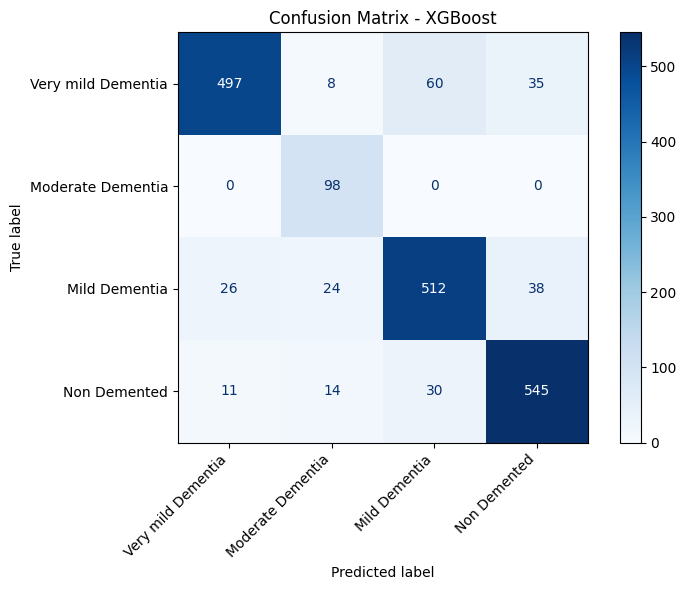

In [80]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=class_names
)

fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(cmap="Blues", values_format='d', ax=ax)

ax.set_xticklabels(class_names, rotation=45, ha='right')
ax.set_yticklabels(class_names, rotation=0)

plt.title("Confusion Matrix - XGBoost")
plt.tight_layout()
plt.show()


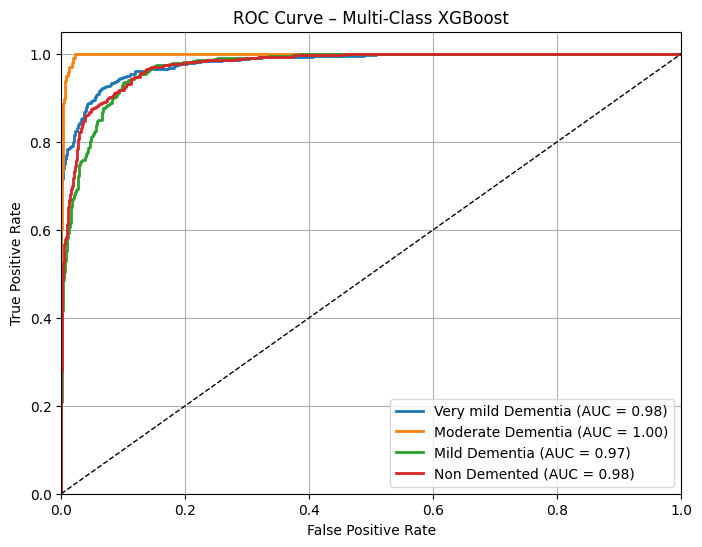

In [83]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

y_score = xgb_model.predict_proba(X_test_scaled)

n_classes = len(class_names)

y_test_bin = label_binarize(y_test, classes=list(range(n_classes)))

plt.figure(figsize=(8, 6))

for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)

    plt.plot(
        fpr,
        tpr,
        lw=2,
        label=f"{class_names[i]} (AUC = {roc_auc:.2f})"
    )
# Random classifier reference line
plt.plot([0, 1], [0, 1], 'k--', lw=1)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Multi-Class XGBoost")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


In [73]:
print("Train size:", len(X_train))
print("Test size:", len(X_test))


Train size: 7590
Test size: 1898
